# Dominik Strzałko (SnowyCocoon) - Predicting the rain in Australia
We will be comparing 5 different methods to predict the rain:
1. Logistic Regresion
3. Decision Trees
2. Random Forest
4. KNeighborsClassifier
5. Neural Network (Built in pytorch)

Dataset from:
- https://www.kaggle.com/jsphyg/weather-dataset-rattle-package


List of helpfull notebooks:
- https://www.kaggle.com/aninditapani/will-it-rain-tomorrow
- https://www.kaggle.com/prashant111/logistic-regression-classifier-tutorial
- https://www.kaggle.com/rafetcan/red-wine-quality-classification-95-76-acc

# 0. Importing the libriaries and data

In [1]:
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
from scipy.stats import norm
#from sklearn.utils import resample

In [2]:
df = pd.read_csv('weatherAUS.csv') #Reading the csv

In [3]:
df.head() #Displaying the first 5 rows of the dataframe 

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# 1. Preprocessing the data

### 1.1. Handling the NA/Null/Empty values

In [4]:
df.count().sort_values() #Checking how many values each column have.

Sunshine          75625
Evaporation       82670
Cloud3pm          86102
Cloud9am          89572
Pressure9am      130395
Pressure3pm      130432
WindDir9am       134894
WindGustDir      135134
WindGustSpeed    135197
Humidity3pm      140953
WindDir3pm       141232
Temp3pm          141851
RainTomorrow     142193
RainToday        142199
Rainfall         142199
WindSpeed3pm     142398
Humidity9am      142806
Temp9am          143693
WindSpeed9am     143693
MinTemp          143975
MaxTemp          144199
Location         145460
Date             145460
dtype: int64

In [5]:
df.isna().sum().sort_values() #Checking how many missing values each column have.

Date                 0
Location             0
MaxTemp           1261
MinTemp           1485
Temp9am           1767
WindSpeed9am      1767
Humidity9am       2654
WindSpeed3pm      3062
Rainfall          3261
RainToday         3261
RainTomorrow      3267
Temp3pm           3609
WindDir3pm        4228
Humidity3pm       4507
WindGustSpeed    10263
WindGustDir      10326
WindDir9am       10566
Pressure3pm      15028
Pressure9am      15065
Cloud9am         55888
Cloud3pm         59358
Evaporation      62790
Sunshine         69835
dtype: int64

In [6]:
df = df.drop(columns=['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','Date'],axis=1) #We are droping all columns with less than 60% of data

In [7]:
df = df.dropna(how='any') #We are dropping all the rows with any missing value.

### 1.2. Dealing with outliers
https://en.wikipedia.org/wiki/Outlier

We are calculating the Z-score of for every value in the dataframe. If the Z-score is going to be bigger than 3, then we are going to delete the whole row with one or more outliers. The highes the Z-score is, the more unusual the data is!

![title](https://raw.githubusercontent.com/SnowyCocoon/Data-Science-Projects/main/11.%20Rain%20Classification%20using%205%20different%20classification%20models/Img1.png)

source(https://en.wikipedia.org/wiki/Z-test)

![title](https://github.com/SnowyCocoon/Data-Science-Projects/blob/main/11.%20Rain%20Classification%20using%205%20different%20classification%20models/Img2.png?raw=true)

source (https://www.dummies.com/education/math/statistics/how-to-calculate-a-confidence-interval-for-a-population-mean-when-you-know-its-standard-deviation/)

In [8]:
from scipy import stats

z = np.abs(stats.zscore(df._get_numeric_data()))
print(z)
df= df[(z < 3).all(axis=1)]
print(df.shape)

[[0.11756741 0.10822071 0.20666127 ... 1.14245477 0.08843526 0.04787026]
 [0.84180219 0.20684494 0.27640495 ... 1.04184813 0.04122846 0.31776848]
 [0.03761995 0.29277194 0.27640495 ... 0.91249673 0.55672435 0.15688743]
 ...
 [1.44940294 0.23548728 0.27640495 ... 0.58223051 1.03257127 0.34701958]
 [1.16159206 0.46462594 0.27640495 ... 0.25166583 0.78080166 0.58102838]
 [0.77784422 0.4789471  0.27640495 ... 0.2085487  0.37167606 0.56640283]]
(107868, 17)


### 1.3. Dealing with categorical data (in string format)

In [9]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

In [10]:
categorical_columns = ['WindGustDir', 'WindDir3pm', 'WindDir9am']
df = pd.get_dummies(df, columns=categorical_columns)

### 1.4. Standarizing/Normalizing our data

In [11]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

### 1.5. Selecting the features to include in our model

In [12]:
from sklearn.feature_selection import SelectKBest, chi2

X = df.loc[:,df.columns!='RainTomorrow']
y = df[['RainTomorrow']]

selector = SelectKBest(chi2, k=3)
selector.fit(X, y)

X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)]) #top 3 columns

Index(['Rainfall', 'Humidity3pm', 'RainToday'], dtype='object')


### 1.6. Analysing the top 3 columns

Probability Plots are looking already fine, because we deleted the outliers!

#### 1.6.1. Humidity at 3 PM

In [13]:
df[["Humidity3pm","RainTomorrow"]].groupby(["RainTomorrow"], as_index = False).mean().sort_values(by = "RainTomorrow").style.background_gradient("Reds")

,RainTomorrow,Humidity3pm
0,0.000000,0.457204
1,1.000000,0.679920


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


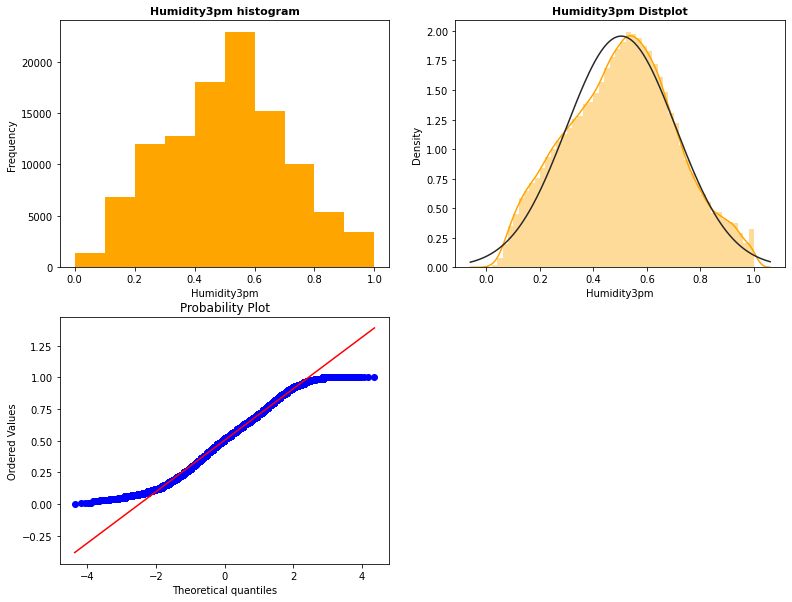

In [14]:
plt.figure(figsize=(13,10))
plt.subplot(2,2,1)
plt.hist(df["Humidity3pm"], color="orange")
plt.xlabel("Humidity3pm")
plt.ylabel("Frequency")
plt.title("Humidity3pm histogram", color = "black", fontweight='bold', fontsize = 11)
plt.subplot(2,2,2)
sns.distplot(df["Humidity3pm"], fit=norm, color="orange")
plt.title("Humidity3pm Distplot", color = "black", fontweight='bold', fontsize = 11)
plt.subplot(2,2,3)
stats.probplot(df["Humidity3pm"], plot = plt)

plt.show()

#### 1.6.2. Rainfall

In [15]:
df[["Rainfall","RainTomorrow"]].groupby(["RainTomorrow"], as_index = False).mean().sort_values(by = "RainTomorrow").style.background_gradient("Reds")

,RainTomorrow,Rainfall
0,0.000000,0.033865
1,1.000000,0.125855


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


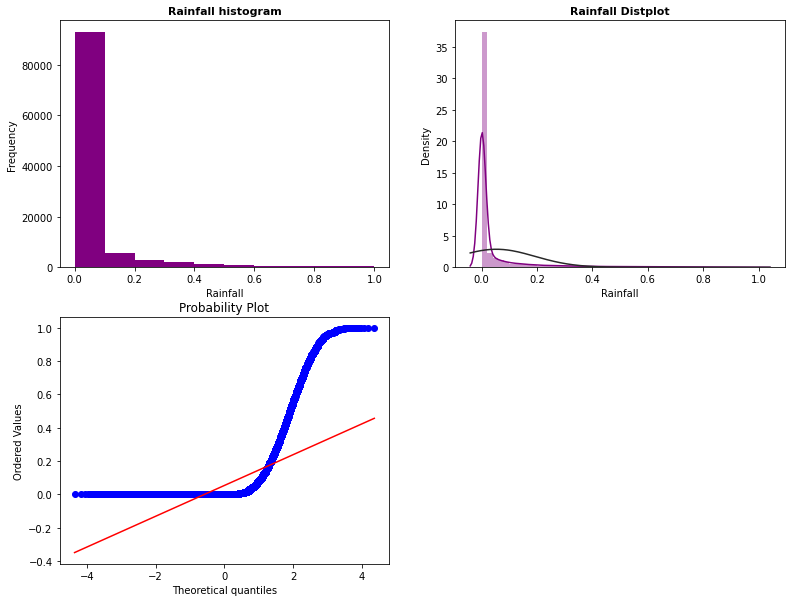

In [16]:
plt.figure(figsize=(13,10))
plt.subplot(2,2,1)
plt.hist(df["Rainfall"], color="purple")
plt.xlabel("Rainfall")
plt.ylabel("Frequency")
plt.title("Rainfall histogram", color = "black", fontweight='bold', fontsize = 11)
plt.subplot(2,2,2)
sns.distplot(df["Rainfall"], fit=norm, color="purple")
plt.title("Rainfall Distplot", color = "black", fontweight='bold', fontsize = 11)
plt.subplot(2,2,3)
stats.probplot(df["Rainfall"], plot = plt)

plt.show()

#### 1.6.3. Rain Today

In [17]:
df[["RainToday","RainTomorrow"]].groupby(["RainTomorrow"], as_index = False).mean().sort_values(by = "RainTomorrow").style.background_gradient("Reds")

,RainTomorrow,RainToday
0,0.000000,0.147961
1,1.000000,0.437190


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


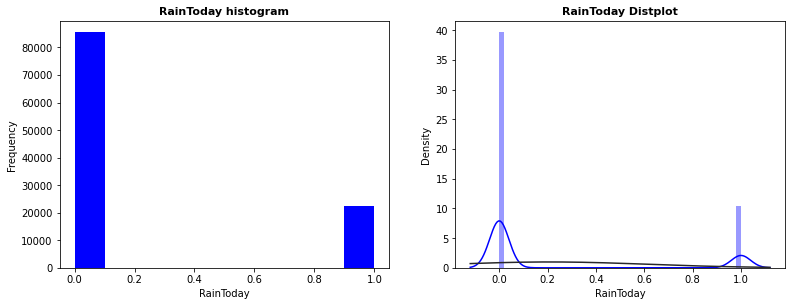

In [18]:
plt.figure(figsize=(13,10))
plt.subplot(2,2,1)
plt.hist(df["RainToday"], color="blue")
plt.xlabel("RainToday")
plt.ylabel("Frequency")
plt.title("RainToday histogram", color = "black", fontweight='bold', fontsize = 11)
plt.subplot(2,2,2)
sns.distplot(df["RainToday"], fit=norm, color="blue")
plt.title("RainToday Distplot", color = "black", fontweight='bold', fontsize = 11)

plt.show()

### 1.7. Spliting the data

In [19]:
X = df[['Humidity3pm','Rainfall','RainToday']]
y = df[['RainTomorrow']]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f'Number of rows in train dataset: \n{X_train.count()} \n')
print(f'Number of rows in test dataset: \n{X_test.count()}')

Number of rows in train dataset: 
Humidity3pm    86294
Rainfall       86294
RainToday      86294
dtype: int64 

Number of rows in test dataset: 
Humidity3pm    21574
Rainfall       21574
RainToday      21574
dtype: int64


### 1.8. Upsampling (not used)

Upsampling can really help us to get more equal f1 score (between 2 classes), but we dont want do use it here. We can recive better accuracy without up/downsampling because there are a lot more days without rain.

In [21]:
from imblearn.over_sampling import SMOTE
import collections

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [22]:
'''
sm = SMOTE(random_state=14)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
'''

'\nsm = SMOTE(random_state=14)\nX_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)\n'

# 2. Creating and Fitting the Models + Evaluation

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

classes = ['No rain', 'Raining']

### 2.1. Logistic Regresion

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
clf_logreg = LogisticRegression(random_state=0)
clf_logreg.fit(X_train,y_train)

y_pred_1 = clf_logreg.predict(X_test)
score_1 = accuracy_score(y_test,y_pred_1)

print(classification_report(y_test, y_pred_1, target_names=classes))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy : 0.8414294984703811
              precision    recall  f1-score   support

     No rain       0.86      0.96      0.91     17104
     Raining       0.73      0.38      0.50      4470

    accuracy                           0.84     21574
   macro avg       0.79      0.67      0.70     21574
weighted avg       0.83      0.84      0.82     21574



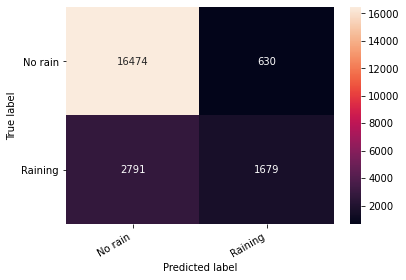

In [26]:
cm = confusion_matrix(y_test, y_pred_1)

df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

### 2.2. Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(X_train,y_train)

y_pred_2 = clf_dt.predict(X_test)
score_2 = accuracy_score(y_test,y_pred_2)

print(classification_report(y_test, y_pred_2, target_names=classes))

Accuracy : 0.8328080096412348
              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     17104
     Raining       0.69      0.36      0.47      4470

    accuracy                           0.83     21574
   macro avg       0.77      0.66      0.68     21574
weighted avg       0.82      0.83      0.81     21574



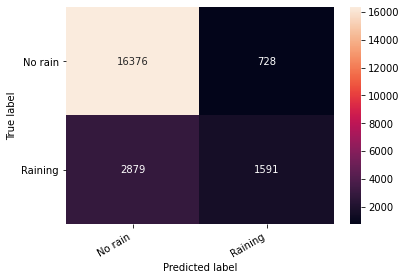

In [29]:
cm = confusion_matrix(y_test, y_pred_2)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

### 2.3. Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0)
clf_rf.fit(X_train,y_train)

y_pred_3 = clf_rf.predict(X_test)
score_3 = accuracy_score(y_test,y_pred_3)

print(classification_report(y_test, y_pred_3, target_names=classes))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy : 0.842263836099008
              precision    recall  f1-score   support

     No rain       0.86      0.96      0.91     17104
     Raining       0.73      0.38      0.50      4470

    accuracy                           0.84     21574
   macro avg       0.79      0.67      0.70     21574
weighted avg       0.83      0.84      0.82     21574



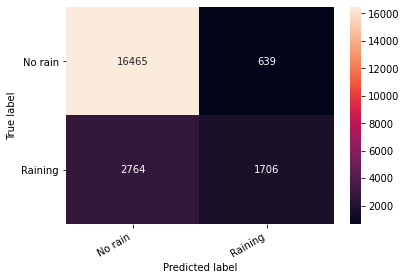

In [32]:
cm = confusion_matrix(y_test, y_pred_3)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

### 2.4. KNeighborsClassifier

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)

y_pred_4 = knn.predict(X_test)
score_4 = accuracy_score(y_test,y_pred_4)

print(classification_report(y_test, y_pred_4, target_names=classes))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Accuracy : 0.8090757393158431
              precision    recall  f1-score   support

     No rain       0.83      0.95      0.89     17104
     Raining       0.58      0.27      0.37      4470

    accuracy                           0.81     21574
   macro avg       0.71      0.61      0.63     21574
weighted avg       0.78      0.81      0.78     21574



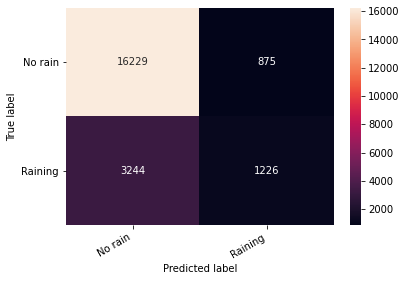

In [35]:
cm = confusion_matrix(y_test, y_pred_4)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

### 2.5. Neural Network (built in pytorch)


In [36]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([86294, 3]) torch.Size([86294])
torch.Size([21574, 3]) torch.Size([21574])


In [37]:
class Net(nn.Module):
  def __init__(self, n_features): # NN Constructor
    super(Net, self).__init__() #super constructor
    self.fc1 = nn.Linear(n_features, 32) #Input to Hidden Layer
    self.fc2 = nn.Linear(32, 16) #Hidden to Hidden Layer
    self.fc3 = nn.Linear(16, 8) #Hidden to Hidden Layer
    self.fc4 = nn.Linear(8, 1) #Hidden to Output Layer
    
  def forward(self, x): #passing outputs to another layers
    x = F.relu(self.fc1(x)) # In to Hid Layer (relu)
    x = F.relu(self.fc2(x)) # In to Hid Layer (relu)
    x = F.relu(self.fc3(x)) # Hid to Hid Layer (relu)
    return torch.sigmoid(self.fc4(x)) # Hid to Out Layer (sigmoid)

net = Net(X_train.shape[1]) 

In [38]:
criterion = nn.BCELoss() #Binary Cross Entropy Loss

In [39]:
optimizer = optim.Adam(net.parameters(), lr=0.001) #Optimizer

In [40]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [41]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

In [42]:
for epoch in range(1000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 50 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
Train set - loss: 0.838, accuracy: 0.208
Test  set - loss: 0.838, accuracy: 0.207

epoch 50
Train set - loss: 0.723, accuracy: 0.234
Test  set - loss: 0.723, accuracy: 0.236

epoch 100
Train set - loss: 0.516, accuracy: 0.792
Test  set - loss: 0.515, accuracy: 0.793

epoch 150
Train set - loss: 0.45, accuracy: 0.8
Test  set - loss: 0.451, accuracy: 0.801

epoch 200
Train set - loss: 0.42, accuracy: 0.825
Test  set - loss: 0.422, accuracy: 0.825

epoch 250
Train set - loss: 0.397, accuracy: 0.832
Test  set - loss: 0.398, accuracy: 0.832

epoch 300
Train set - loss: 0.391, accuracy: 0.839
Test  set - loss: 0.392, accuracy: 0.842

epoch 350
Train set - loss: 0.39, accuracy: 0.84
Test  set - loss: 0.39, accuracy: 0.842

epoch 400
Train set - loss: 0.389, accuracy: 0.84
Test  set - loss: 0.389, accuracy: 0.842

epoch 450
Train set - loss: 0.389, accuracy: 0.84
Test  set - loss: 0.389, accuracy: 0.842

epoch 500
Train set - loss: 0.389, accuracy: 0.84
Test  set - loss: 0.389, accurac

In [43]:
y_pred_5 = net(X_test)
y_pred_5 = y_pred_5.ge(.5).view(-1).cpu()
score_5 = accuracy_score(y_test,y_pred_5)
y_test = y_test.cpu()
print(classification_report(y_test, y_pred_5, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.86      0.96      0.91     17104
     Raining       0.73      0.38      0.50      4470

    accuracy                           0.84     21574
   macro avg       0.79      0.67      0.70     21574
weighted avg       0.83      0.84      0.82     21574



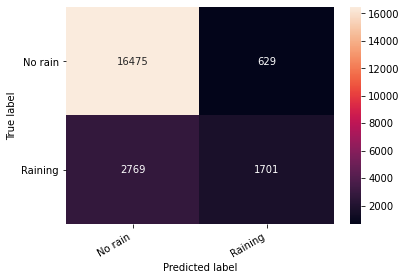

In [44]:
cm = confusion_matrix(y_test, y_pred_5)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

### 2.6. Results

In [45]:
print(f'Scores for different models: \nLinear Regresion {score_1} \nDecision Tree {score_2} \nRandom Forest {score_3} \nKNeighborsClassifier {score_4} \nNeural Network {score_5}')

Scores for different models: 
Linear Regresion 0.8414294984703811 
Decision Tree 0.8328080096412348 
Random Forest 0.842263836099008 
KNeighborsClassifier 0.8090757393158431 
Neural Network 0.8424955965514045
